<a href="https://colab.research.google.com/github/vijayseshachala2003/TensorGo/blob/main/Analyze_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Installing packages and libraries.
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U einops


Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.7 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-p92a6wfr
  Entered build tracker: /tmp/pip-build-tracker-p92a6wfr
  Created temporary directory: /tmp/pip-install-y5klyk58
  Created temporary directory: /tmp/pip-ephem-wheel-cache-ba2cew3b
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  Starting new HTTPS connection (1)

In [ ]:
# @title Demo implementation of utilizing Falcon LLM.


from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
import transformers

model_name = "tiiuae/falcon-7b-instruct"
model = AutoModelForCausalLM.from_pretrained(model_name, load_in_4bit=True, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)

pipe = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)
sequences = pipe(
   "Girafatron is obsessed with giraffes, the most glorious animal on the face of this Earth. Giraftron believes all other animals are irrelevant when compared to the glorious majesty of the giraffe.\nDaniel: Hello, Girafatron!\nGirafatron:",
    max_length=400,
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
)
for seq in sequences:
    print(f"Result: {seq['generated_text']}")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Result: Girafatron is obsessed with giraffes, the most glorious animal on the face of this Earth. Giraftron believes all other animals are irrelevant when compared to the glorious majesty of the giraffe.
Daniel: Hello, Girafatron!
Girafatron: Greetings!
Daniel: Do you want to go to Africa?
Girafatron: Yes! The African savannah is one of Earth's most magnificent places.
Daniel: Girafatron, you can't go to Africa! The African savannah is a thousand miles away from the city!
Girafatron: I know it's far away from the city! But the African savannah would be the ultimate place for any giraffe to visit.


In [ ]:
# @title Import Libraries for Analysis model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from google.colab import files
import seaborn as sns
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


In [ ]:
#@title Code to take input

def load_data_from_csv(uploaded_file):
  """Loads data from an uploaded CSV file."""
  data = pd.read_csv(io.StringIO(uploaded_file.decode('utf-8')))
  return data

In [ ]:
# @title Handling missing values and data formatting for LLM.
# check columns
def columns_missing(data):
  for i in data.columns:
    if data[i].isna().sum() > len(data[i])//2:
      data.drop(i,axis = 1,inplace = True)
  return data
# function to deal with missing values

def missing_values(data):
  columns_missing(data)
  if (data.isna().sum() > 0).any() and (data.isna().sum() < len(data)//2).any(): # Use .any() to check if any value meets the condition
    data = data.fillna(data.mean())
  if (data.isna().sum() > 0).any() and (data.isna().sum() > len(data)//2).any():
    data.interpolate(method = 'linear',limit_direction = 'forward')
  return data

def format_data(data):  # formatting data into text to feed to LLM
  data_str = data.to_string()
  return data_str


In [ ]:
#@title Calculating general stats

def calculate_stats(data):
  """Calculates basic statistical measures."""
  # ... (same as previous response)
  # returing mean,median,mode and corr
  # for better understandong and easier access using pandas
  data = columns_missing(data)
  data = missing_values(data)
  mean = data.mean(numeric_only = True
                   )
  median = data.median(numeric_only = True)
  mode = data.mode(numeric_only= True).iloc[0]
  corr = data.corr(numeric_only = True)
  print("The mean of the data is: "+str(mean))
  print("The median of the data is: "+str(median))
  print("The mode of the data is: "+str(mode))
  print("The correlation of the data is: "+str(corr))
  return mean,median,mode,corr,data.head()


In [ ]:
# @title Plotting using matplotlib

def create_plots(data,numeric_cols,categorical_cols):
  """Creates various plots using matplotlib."""
  # ... (same as previous response)
   # Check for numerical columns
  numeric_cols = numeric_cols


    # Scatter plot for first two numerical columns (if available)
  if len(numeric_cols) > 1:
    length = len(numeric_cols)
    for i in range(length):
      for j in range(i + 1, length):
        plt.figure(figsize=(8, 6))
        plt.scatter(data[numeric_cols[i]], data[numeric_cols[j]])
        plt.xlabel(numeric_cols[i])
        plt.ylabel(numeric_cols[j])
        plt.title(f"Scatter Plot of {numeric_cols[i]} vs {numeric_cols[j]}")
        plt.show()

  # Check for categorical columns
  categorical_cols = categorical_cols
  if len(categorical_cols) > 0:
    # Bar plot for first categorical column
    for i in range(len(categorical_cols)):
      plt.figure(figsize=(8, 6))
      data[categorical_cols[i]].value_counts().plot(kind='bar')
      plt.title(f"Count Plot of {categorical_cols[i]}")
      plt.xlabel(categorical_cols[i])
      plt.ylabel("Count")
      plt.show()
  # working with pie charts for each categorical column
  # groups = data.groupby(categorical_cols)
  # for group_name, group_data in groups:
  #     plt.figure(figsize=(6, 6))
  #     group_data.value_counts().plot(kind='pie', autopct='%1.1f%%')
  #     plt.title(f"Pie Chart for {group_name} using matplotlib")
  #     plt.show()


In [ ]:
#@title Plotting using Pandas
# pandas plots
def pandas_plots(data,categorical_cols,numeric_cols = None):
  # we need not use numeric_cols because we have subplots option in pandas plotting functions which uses entire numerical cols to plot
  data.plot.line(subplots = True,figsize = (10,10))
  plt.title(" Pandas Line Plot")
  plt.show()
  data.plot.bar(subplots = True,figsize = (10,10))
  plt.title(" Pandas Bar Plot")
  plt.show()
  data.plot.hist(subplots = True,figsize = (10,10))
  plt.title(" Pandas Histogram Plot")
  plt.show()
  data.plot.box(subplots = True,figsize = (10,10))
  plt.title(" Pandas Box Plot")
  plt.show()
  # Select only numerical columns for correlation and setting index
  # Pie chart for a categorical column

  for i in categorical_cols:
    plt.figure(figsize=(6, 6))
    data[i].value_counts().plot(kind='pie', autopct='%1.1f%%')  # Display percentages
    plt.title(f"Pie Chart of {i}")
    plt.show()

  print("\n the categorical values are"+str(pd.Series(categorical_cols).value_counts()))



In [ ]:
#@title PLotting using seaborn libraries

def seaborn_plots(data,categorical_cols):
  sns.pairplot(data)
  plt.title("Pair Plot")
  plt.show()


  # Bar chart for a categorical column
  categorical_cols = categorical_cols

  # Loop through each categorical column
  for col in categorical_cols:
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot
    sns.countplot(
        x=col,  # Specify the current column to plot
        data=data
    )
    plt.title(f"Count Plot of {col}")
    plt.xlabel(col)  # Label the x-axis with the column name
    plt.ylabel("Count")
    plt.show()  # Display the plot

In [ ]:
#@title Falcon LLM intialization and tokenization

def generate_llm_response(data, stats, query):
  """Generates an LLM response based on data and stats."""
  # ... (same as previous response)
  model_name = "tiiuae/falcon-7b-instruct"
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForCausalLM.from_pretrained(model_name,
 load_in_4bit=True, device_map="auto")

  # Incorporate stats into the prompt
  mean, median, mode, corr,data_h = stats
  prompt = f"Data summary: Mean: {mean}, Median: {median}, Mode: {mode}, Correlation: {corr}.\nData: {data_h}\nQuestion: {query}"

 # Generate text
  input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
  # Increase max_length or use max_new_tokens
  output = model.generate(input_ids, max_new_tokens=200, do_sample=True)  # Use max_new_tokens instead of max_length
  generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
  return generated_text


In [ ]:
#@title Main function code


def main():
  uploaded = files.upload()
  for fn in uploaded.keys():
    data = load_data_from_csv(uploaded[fn])
    # format data for LLM input
  text_data = format_data(data)
  print(" The sample data is as follows  ",data.head())
  # checking for missing values
  data = missing_values(data)
  print(" The missing values are handled")
  # checking for columns with missing values
  data = columns_missing(data)
  print(" The columns with missing values are dropped")
   # checking for categorical values of the data
  categorical_cols = data.select_dtypes(include='object').columns
  print("The categorical cols are as follows: "+str(categorical_cols))
  # checking for numerical values of the data
  numeric_cols = data.select_dtypes(include=np.number).columns
  print("\n The numerical cols are as follows: "+str(numeric_cols))
   # Perform analysis and generate plots
  print("\n  The statistical analysis is as follows: \n" )
  stats = calculate_stats(data)
  print("\n the correlation matrix can be given as: n")
  print(sns.heatmap(data[numeric_cols].corr(), annot=True,cmap = 'YlGnBu'))
  plt.show()
  print("\n The dynamic plots using pandas are as follows: \n")

  pandas_plots(data,categorical_cols,numeric_cols)
  print(" \n The dynamic plots using matplotlib are as follows: \n")
  create_plots(data,numeric_cols,categorical_cols)
  print(" \n The dynamic plots using seaborn are as follows: \n")
  seaborn_plots(data,categorical_cols)
  print("\n \n The plotting of data is completed, pls continue with any questions \n \n ")

  while True:
    # Example user interaction

    query = input("Enter your question: ")

    response = generate_llm_response(text_data, stats, query)
    print(response)
    rex = input("If you want to continue pls press yes, else no:   ")
    if rex == "yes" or rex == "Yes" or rex == "YES":
        continue
    else:
        break


Saving worldwide_happiness_report.csv to worldwide_happiness_report (13).csv
 The sample data is as follows      Overall rank Country or region  Score  GDP per capita  Social support  \
0             1           Finland  7.769           1.340           1.587   
1             2           Denmark  7.600           1.383           1.573   
2             3            Norway  7.554           1.488           1.582   
3             4           Iceland  7.494           1.380           1.624   
4             5       Netherlands  7.488           1.396           1.522   

   Healthy life expectancy  Freedom to make life choices  Generosity  \
0                    0.986                         0.596       0.153   
1                    0.996                         0.592       0.252   
2                    1.028                         0.603       0.271   
3                    1.026                         0.591       0.354   
4                    0.999                         0.557       0.322   



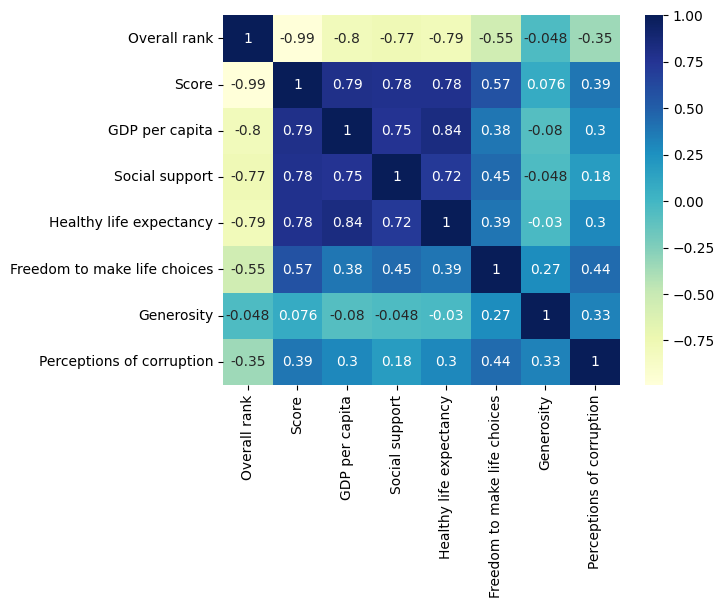


 The dynamic plots using pandas are as follows: 



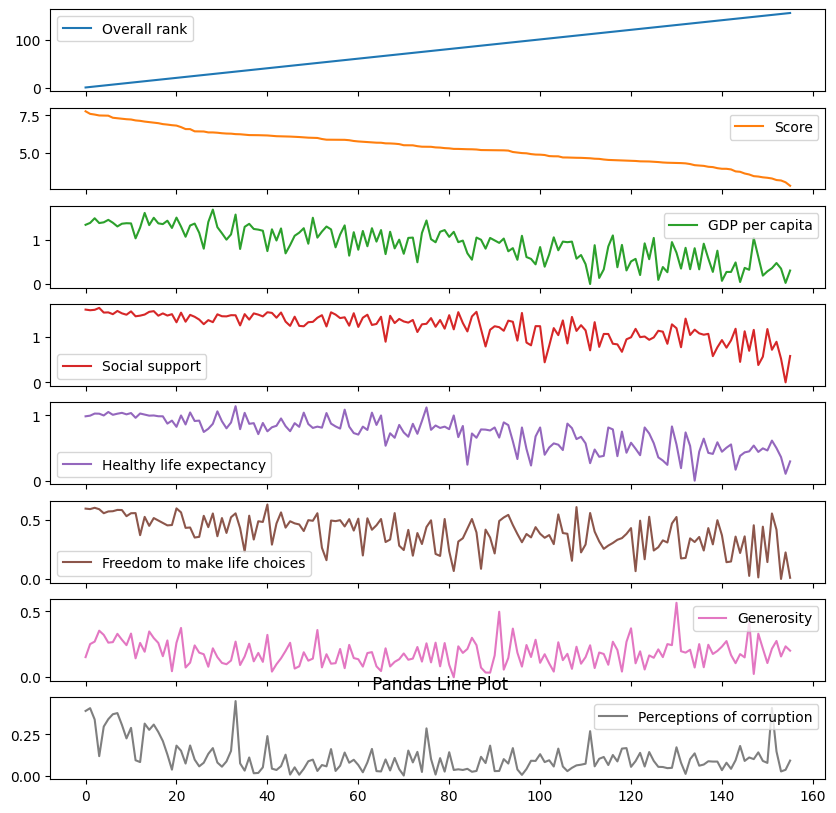

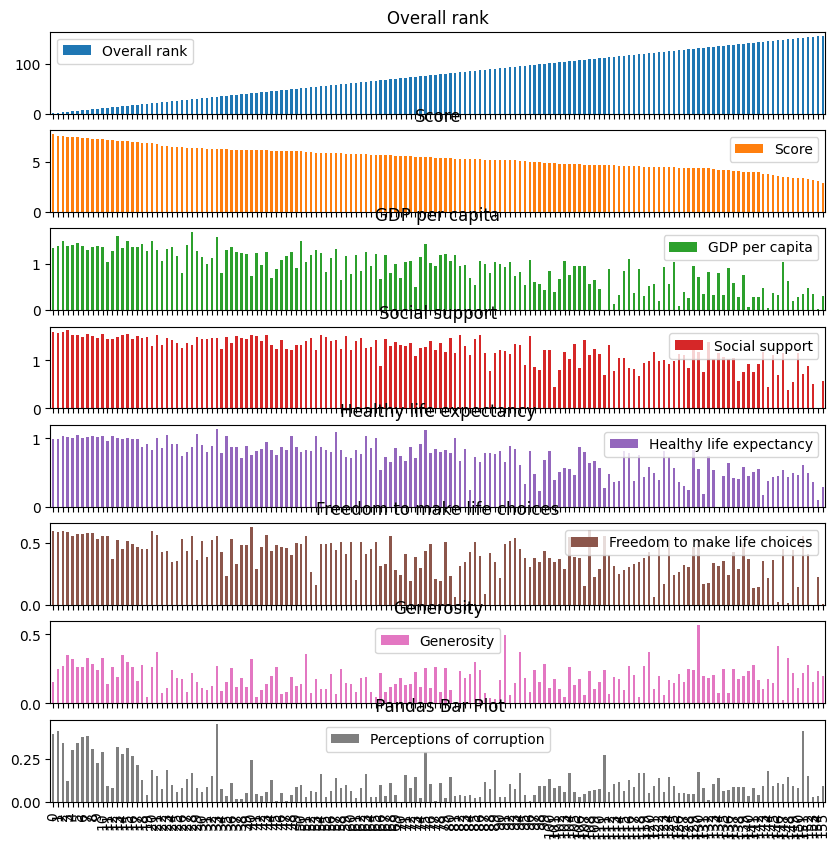

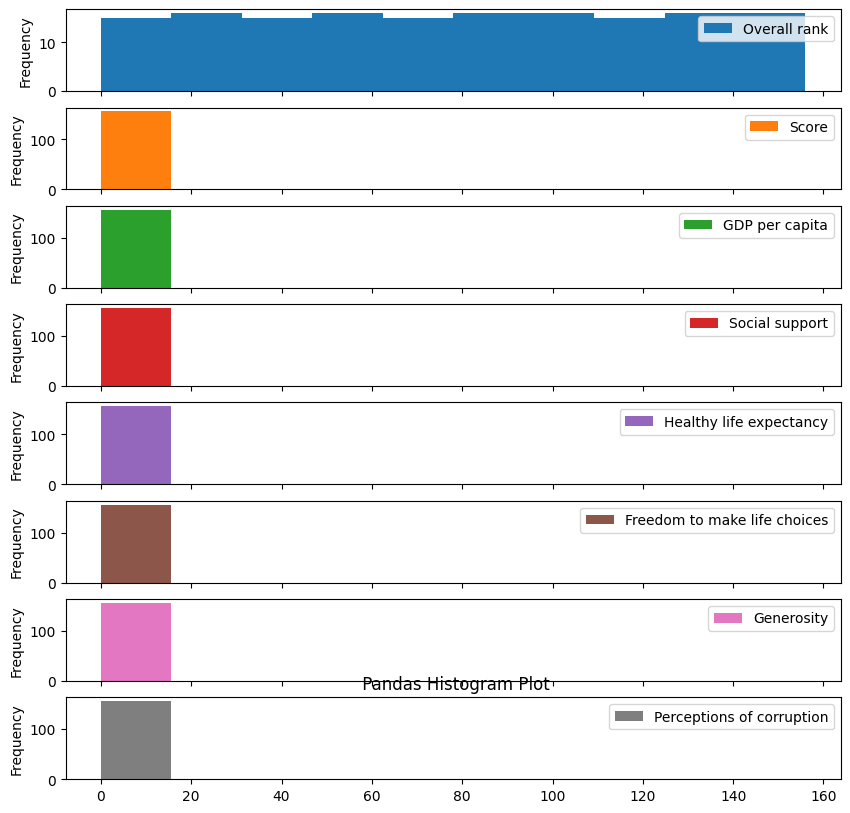

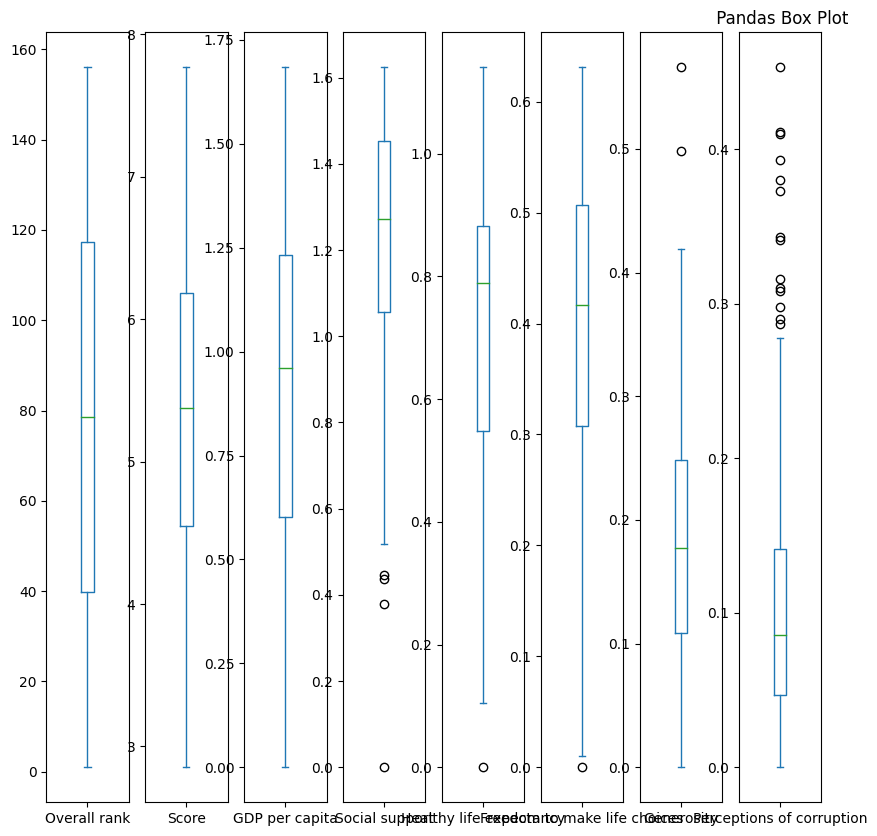

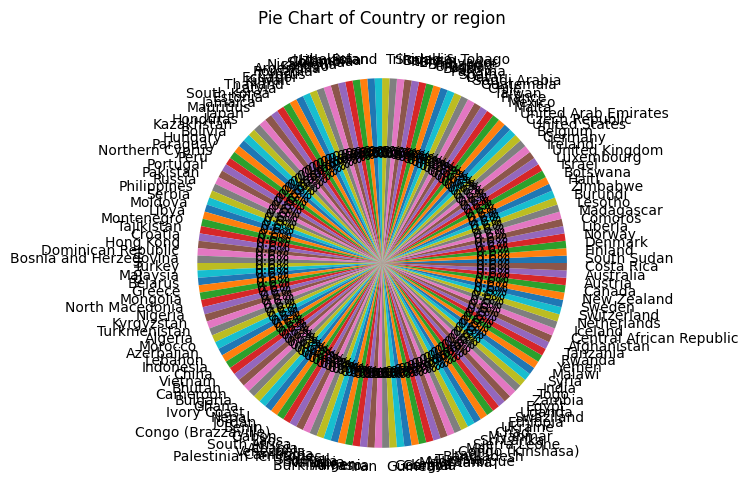


 the categorical values areCountry or region    1
Name: count, dtype: int64
 
 The dynamic plots using matplotlib are as follows: 



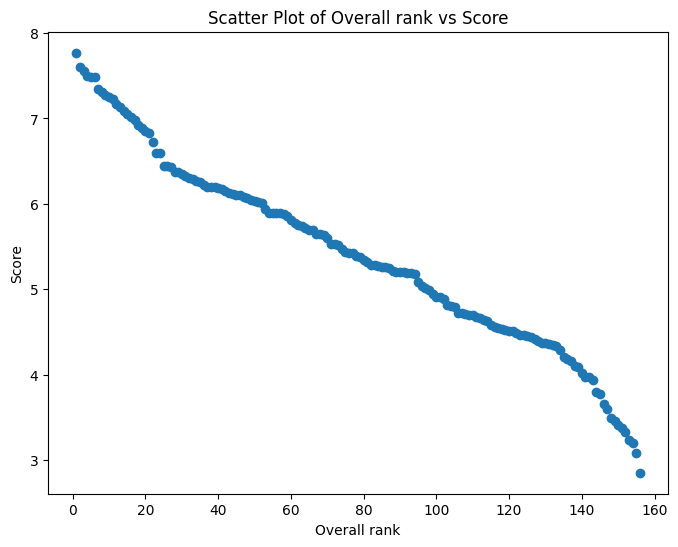

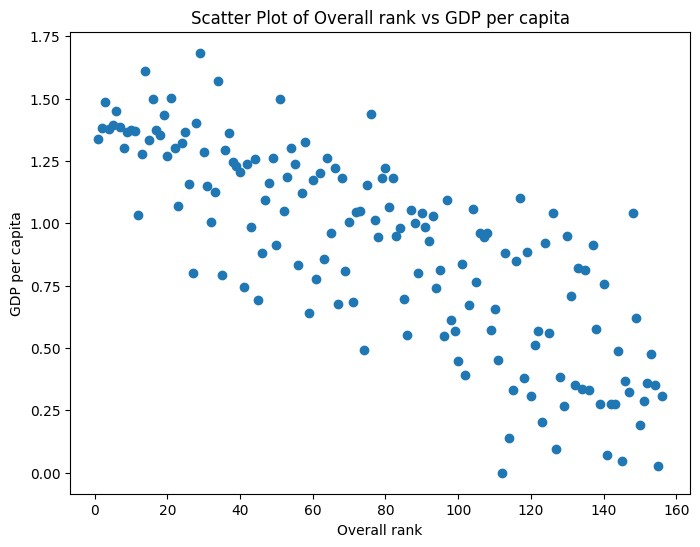

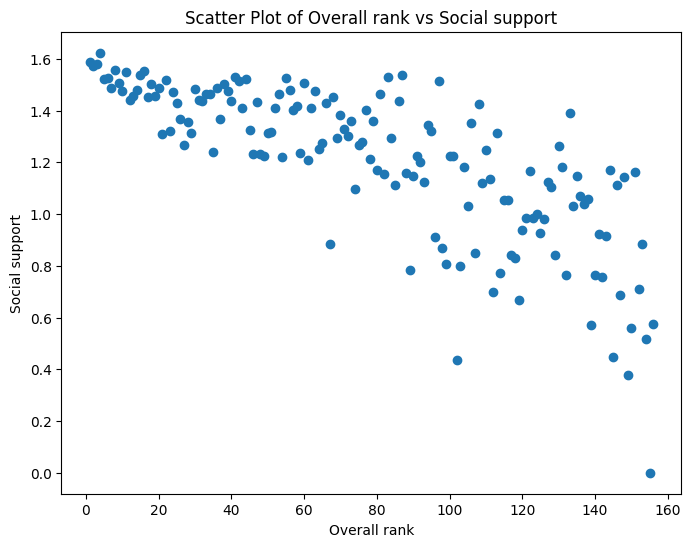

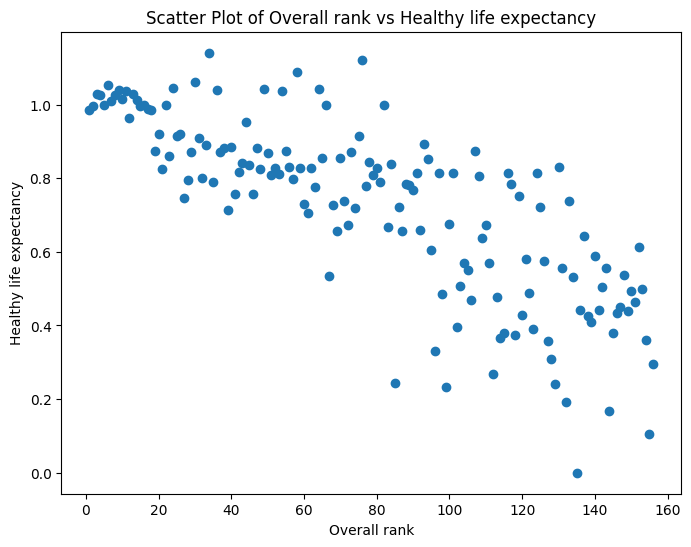

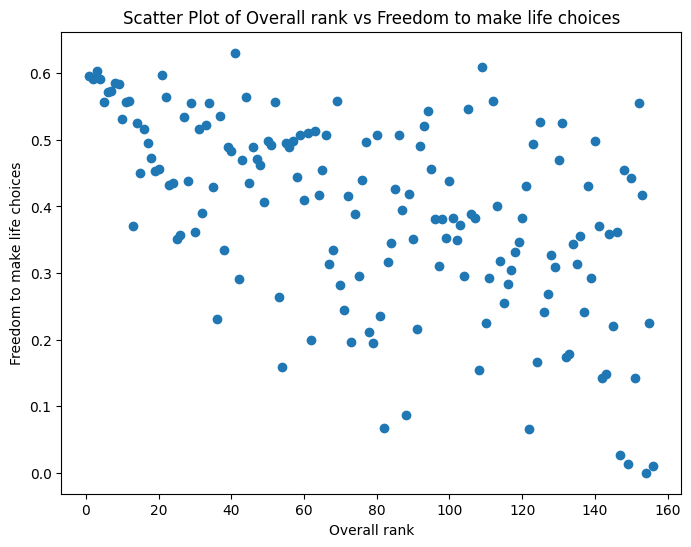

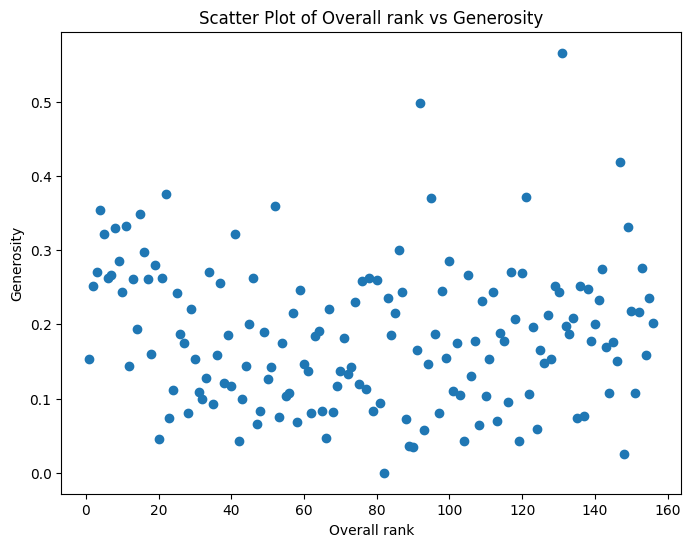

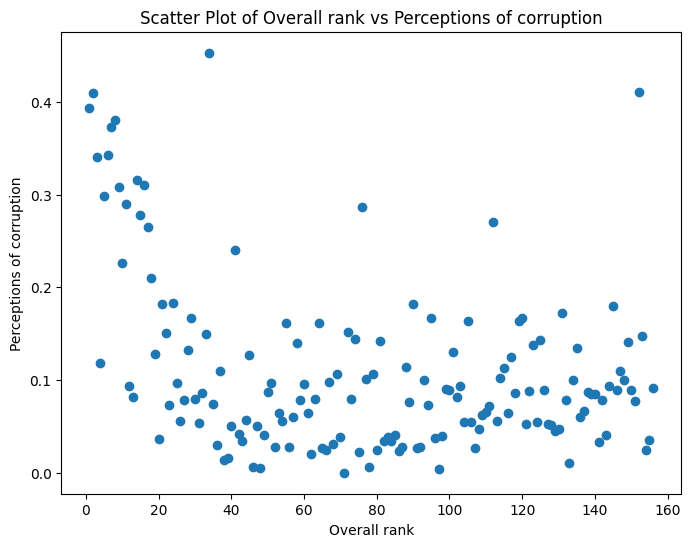

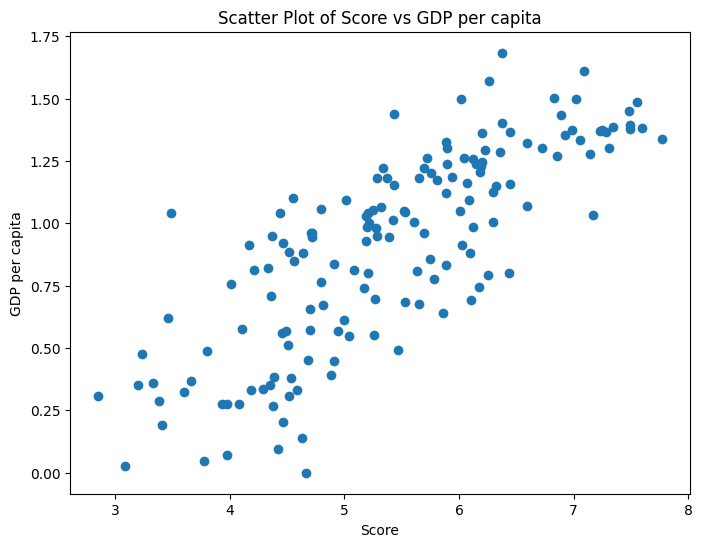

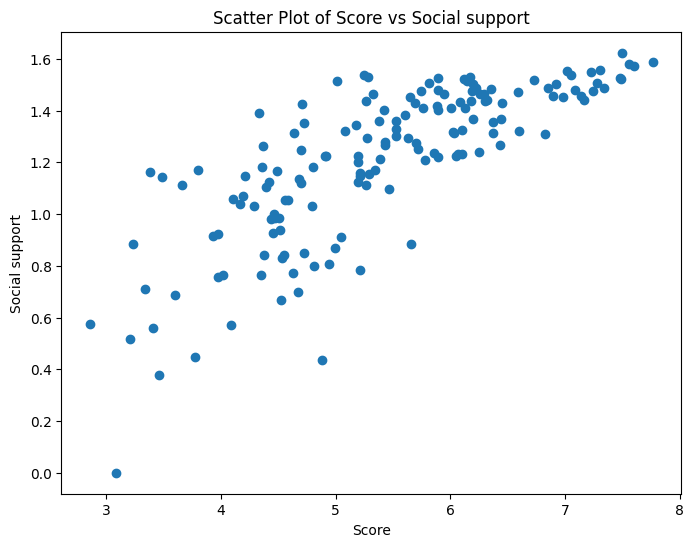

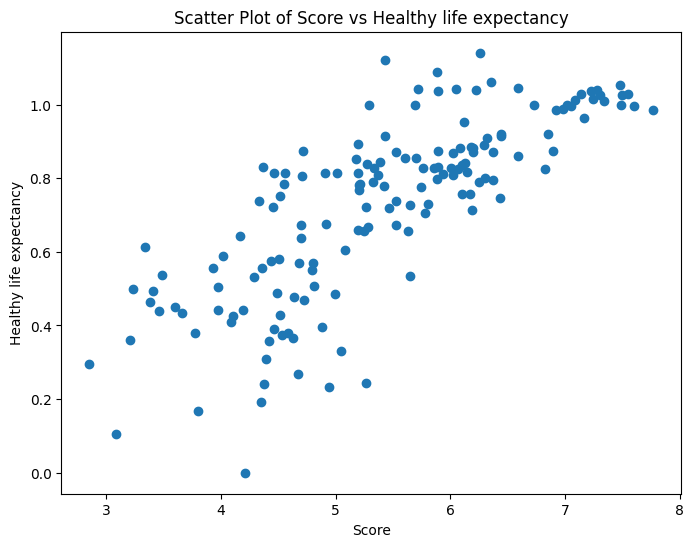

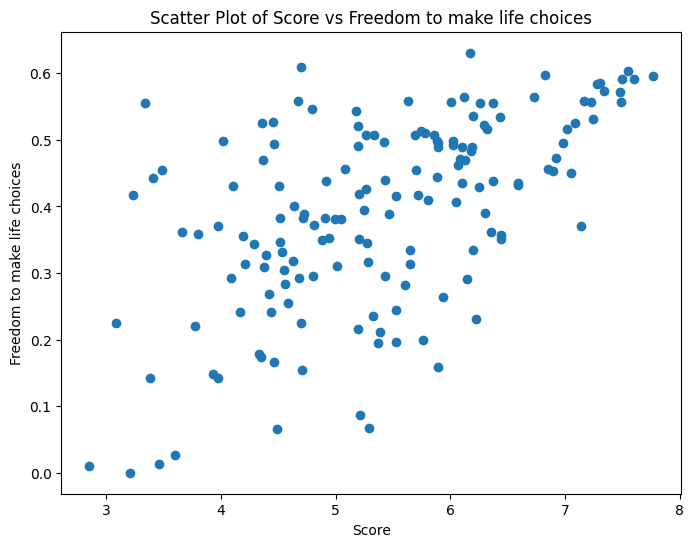

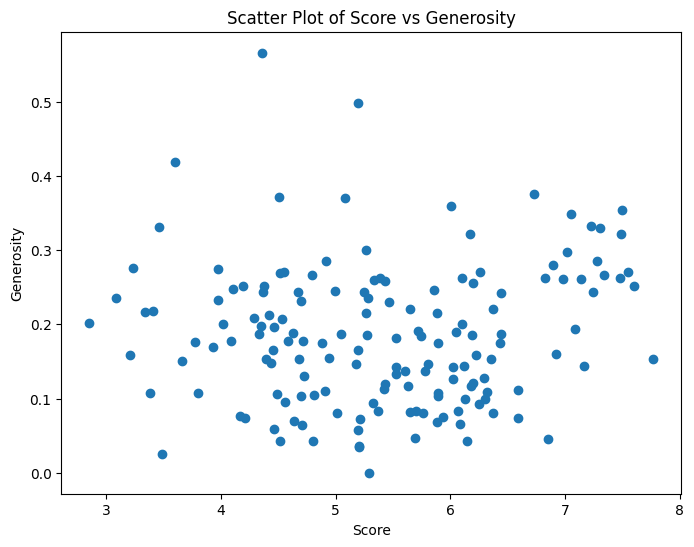

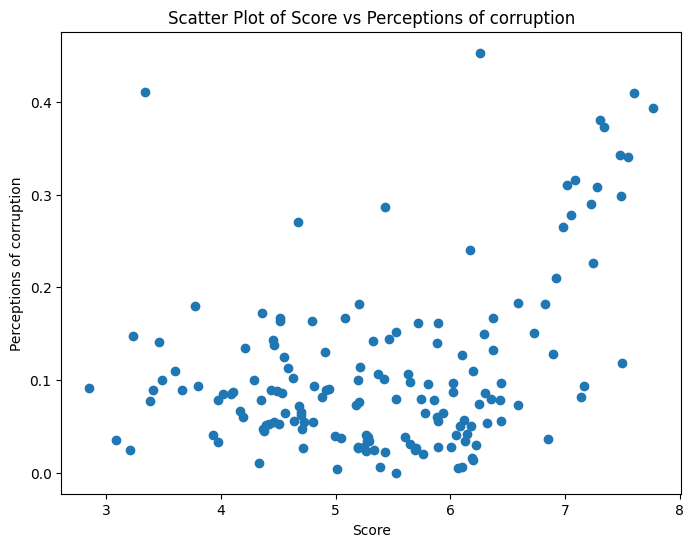

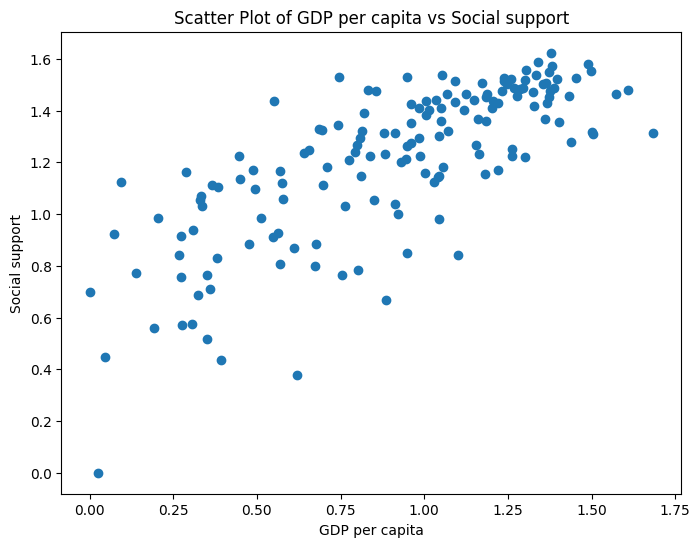

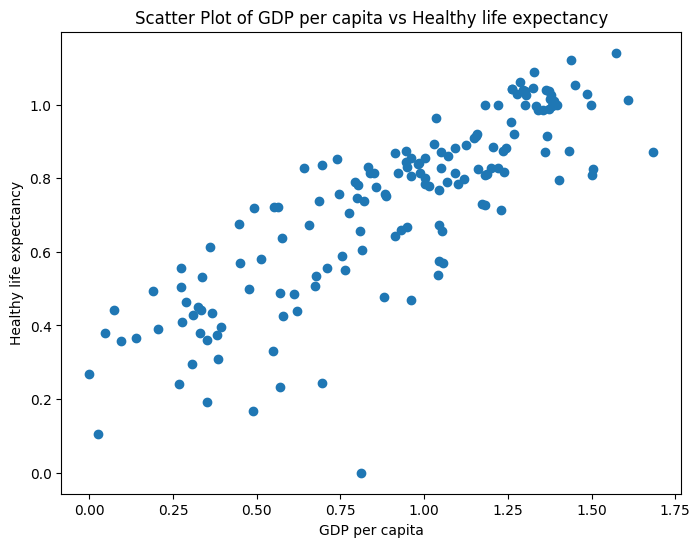

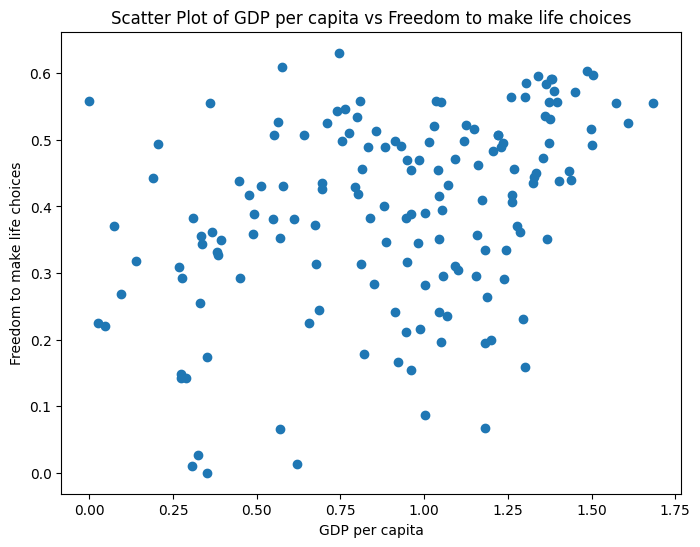

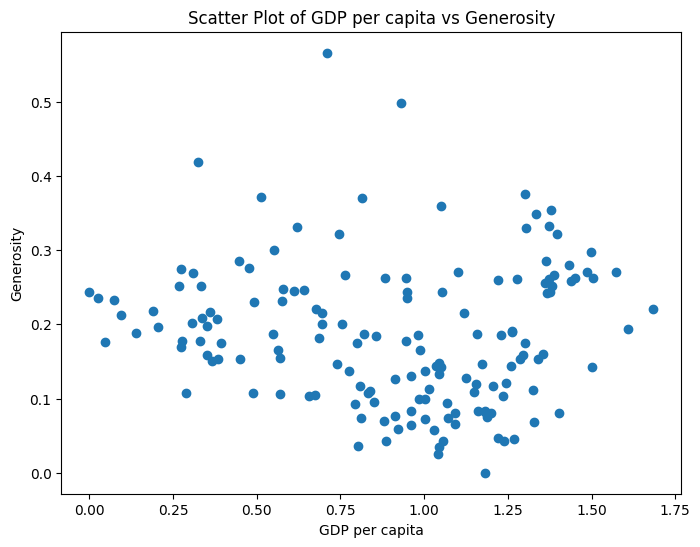

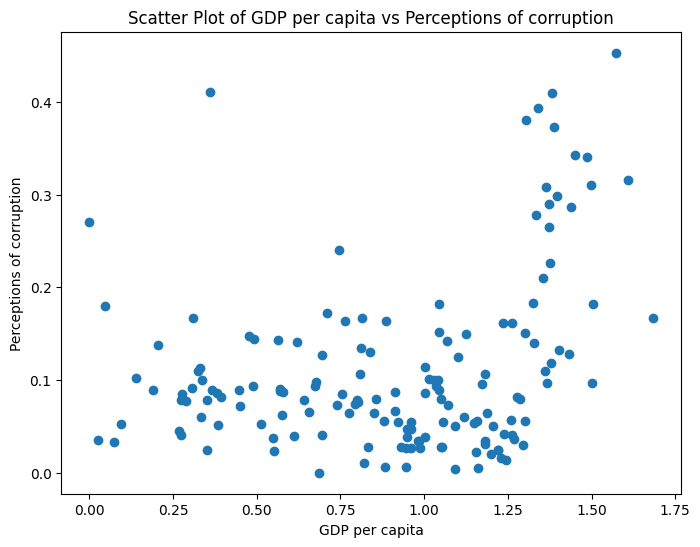

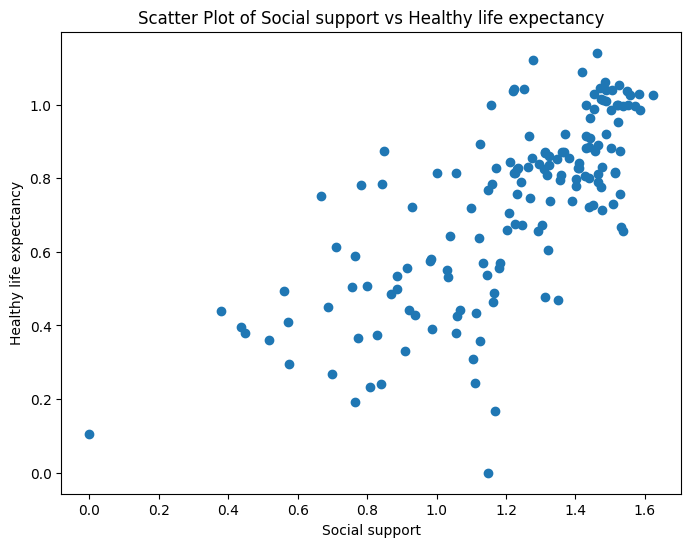

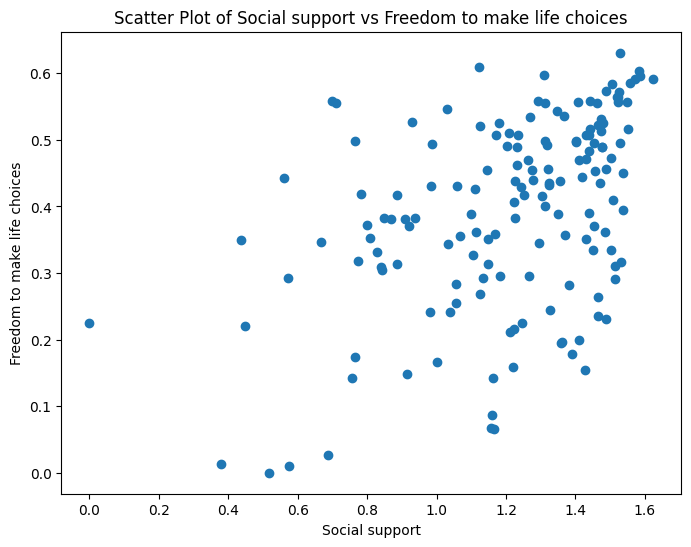

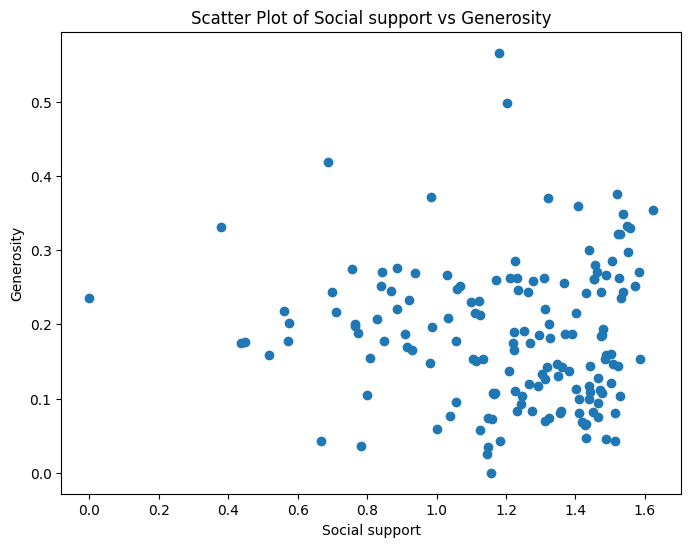

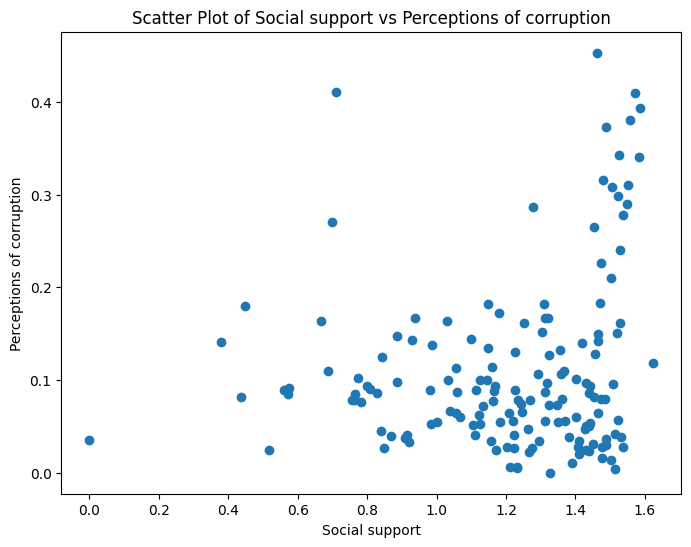

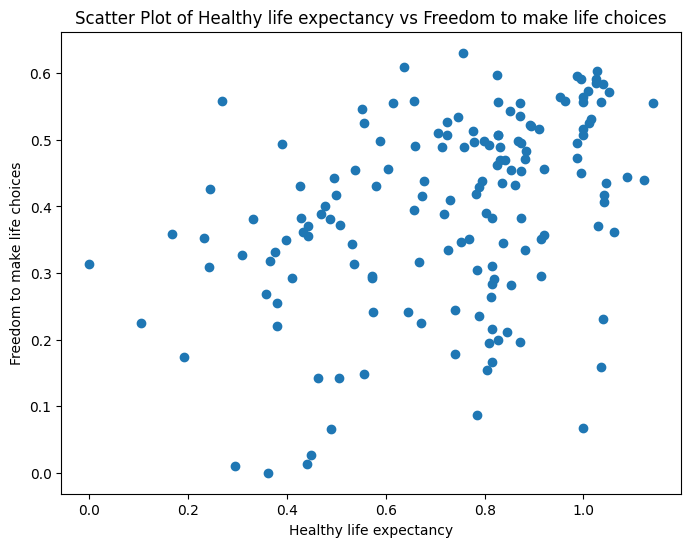

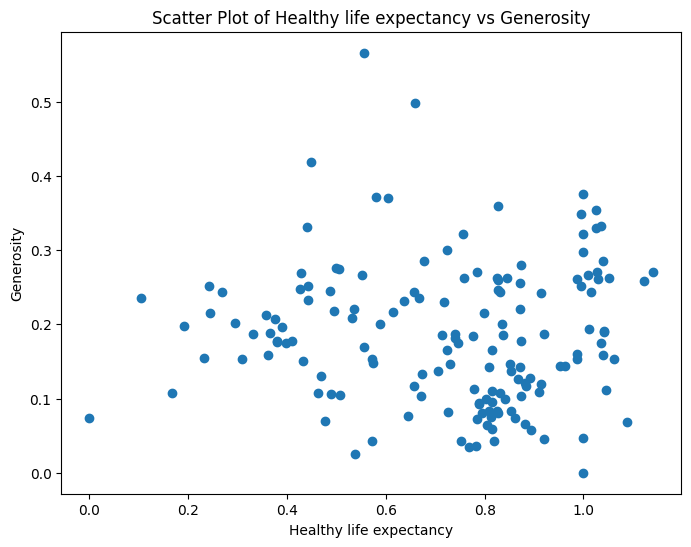

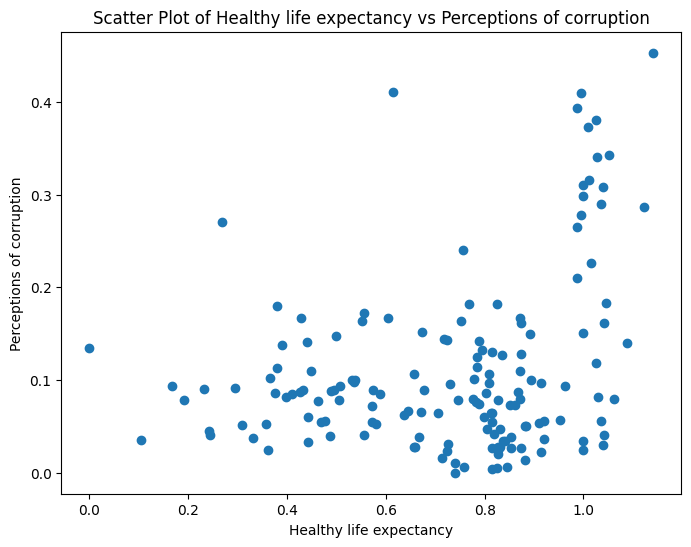

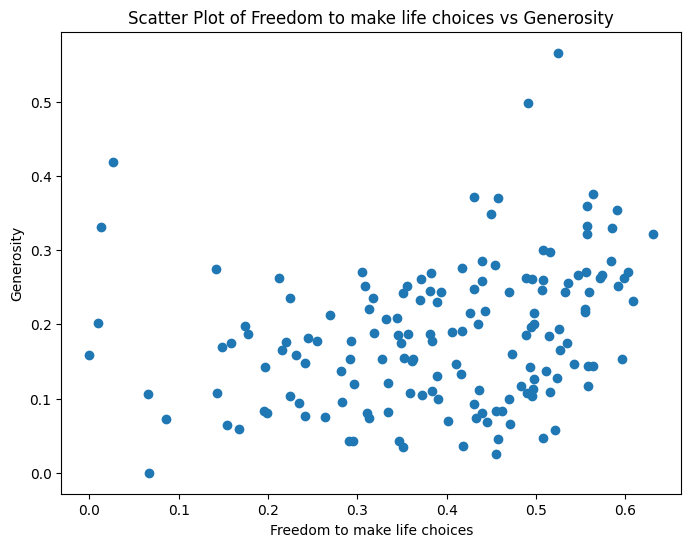

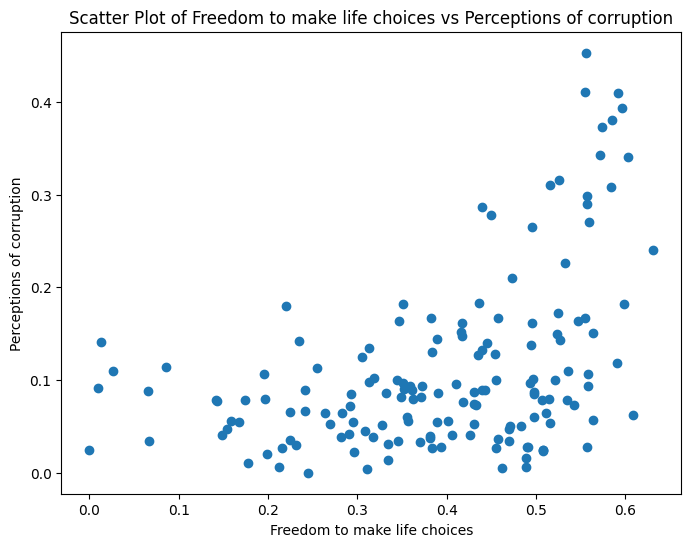

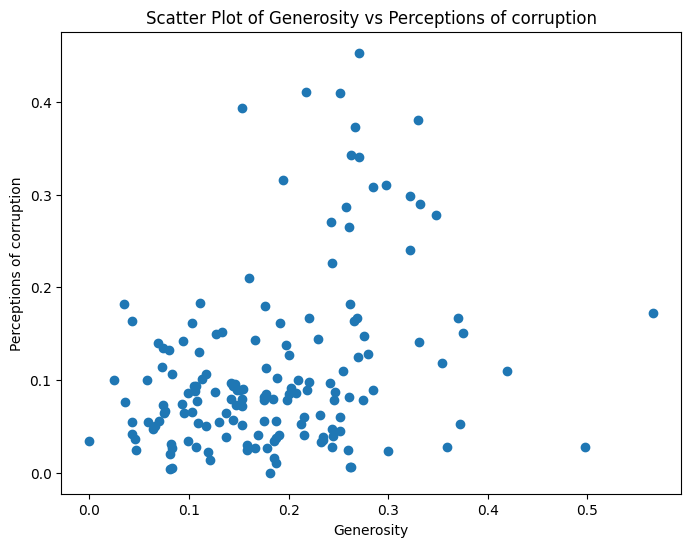

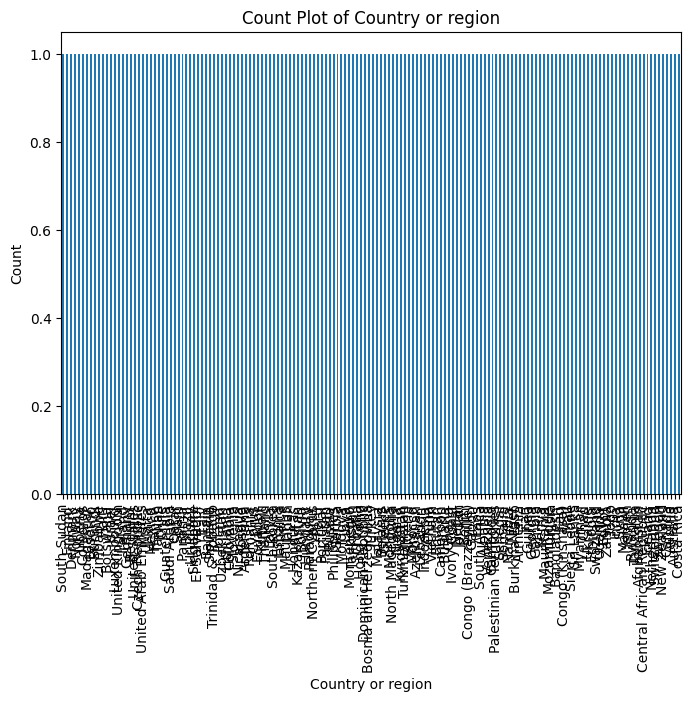

 
 The dynamic plots using seaborn are as follows: 



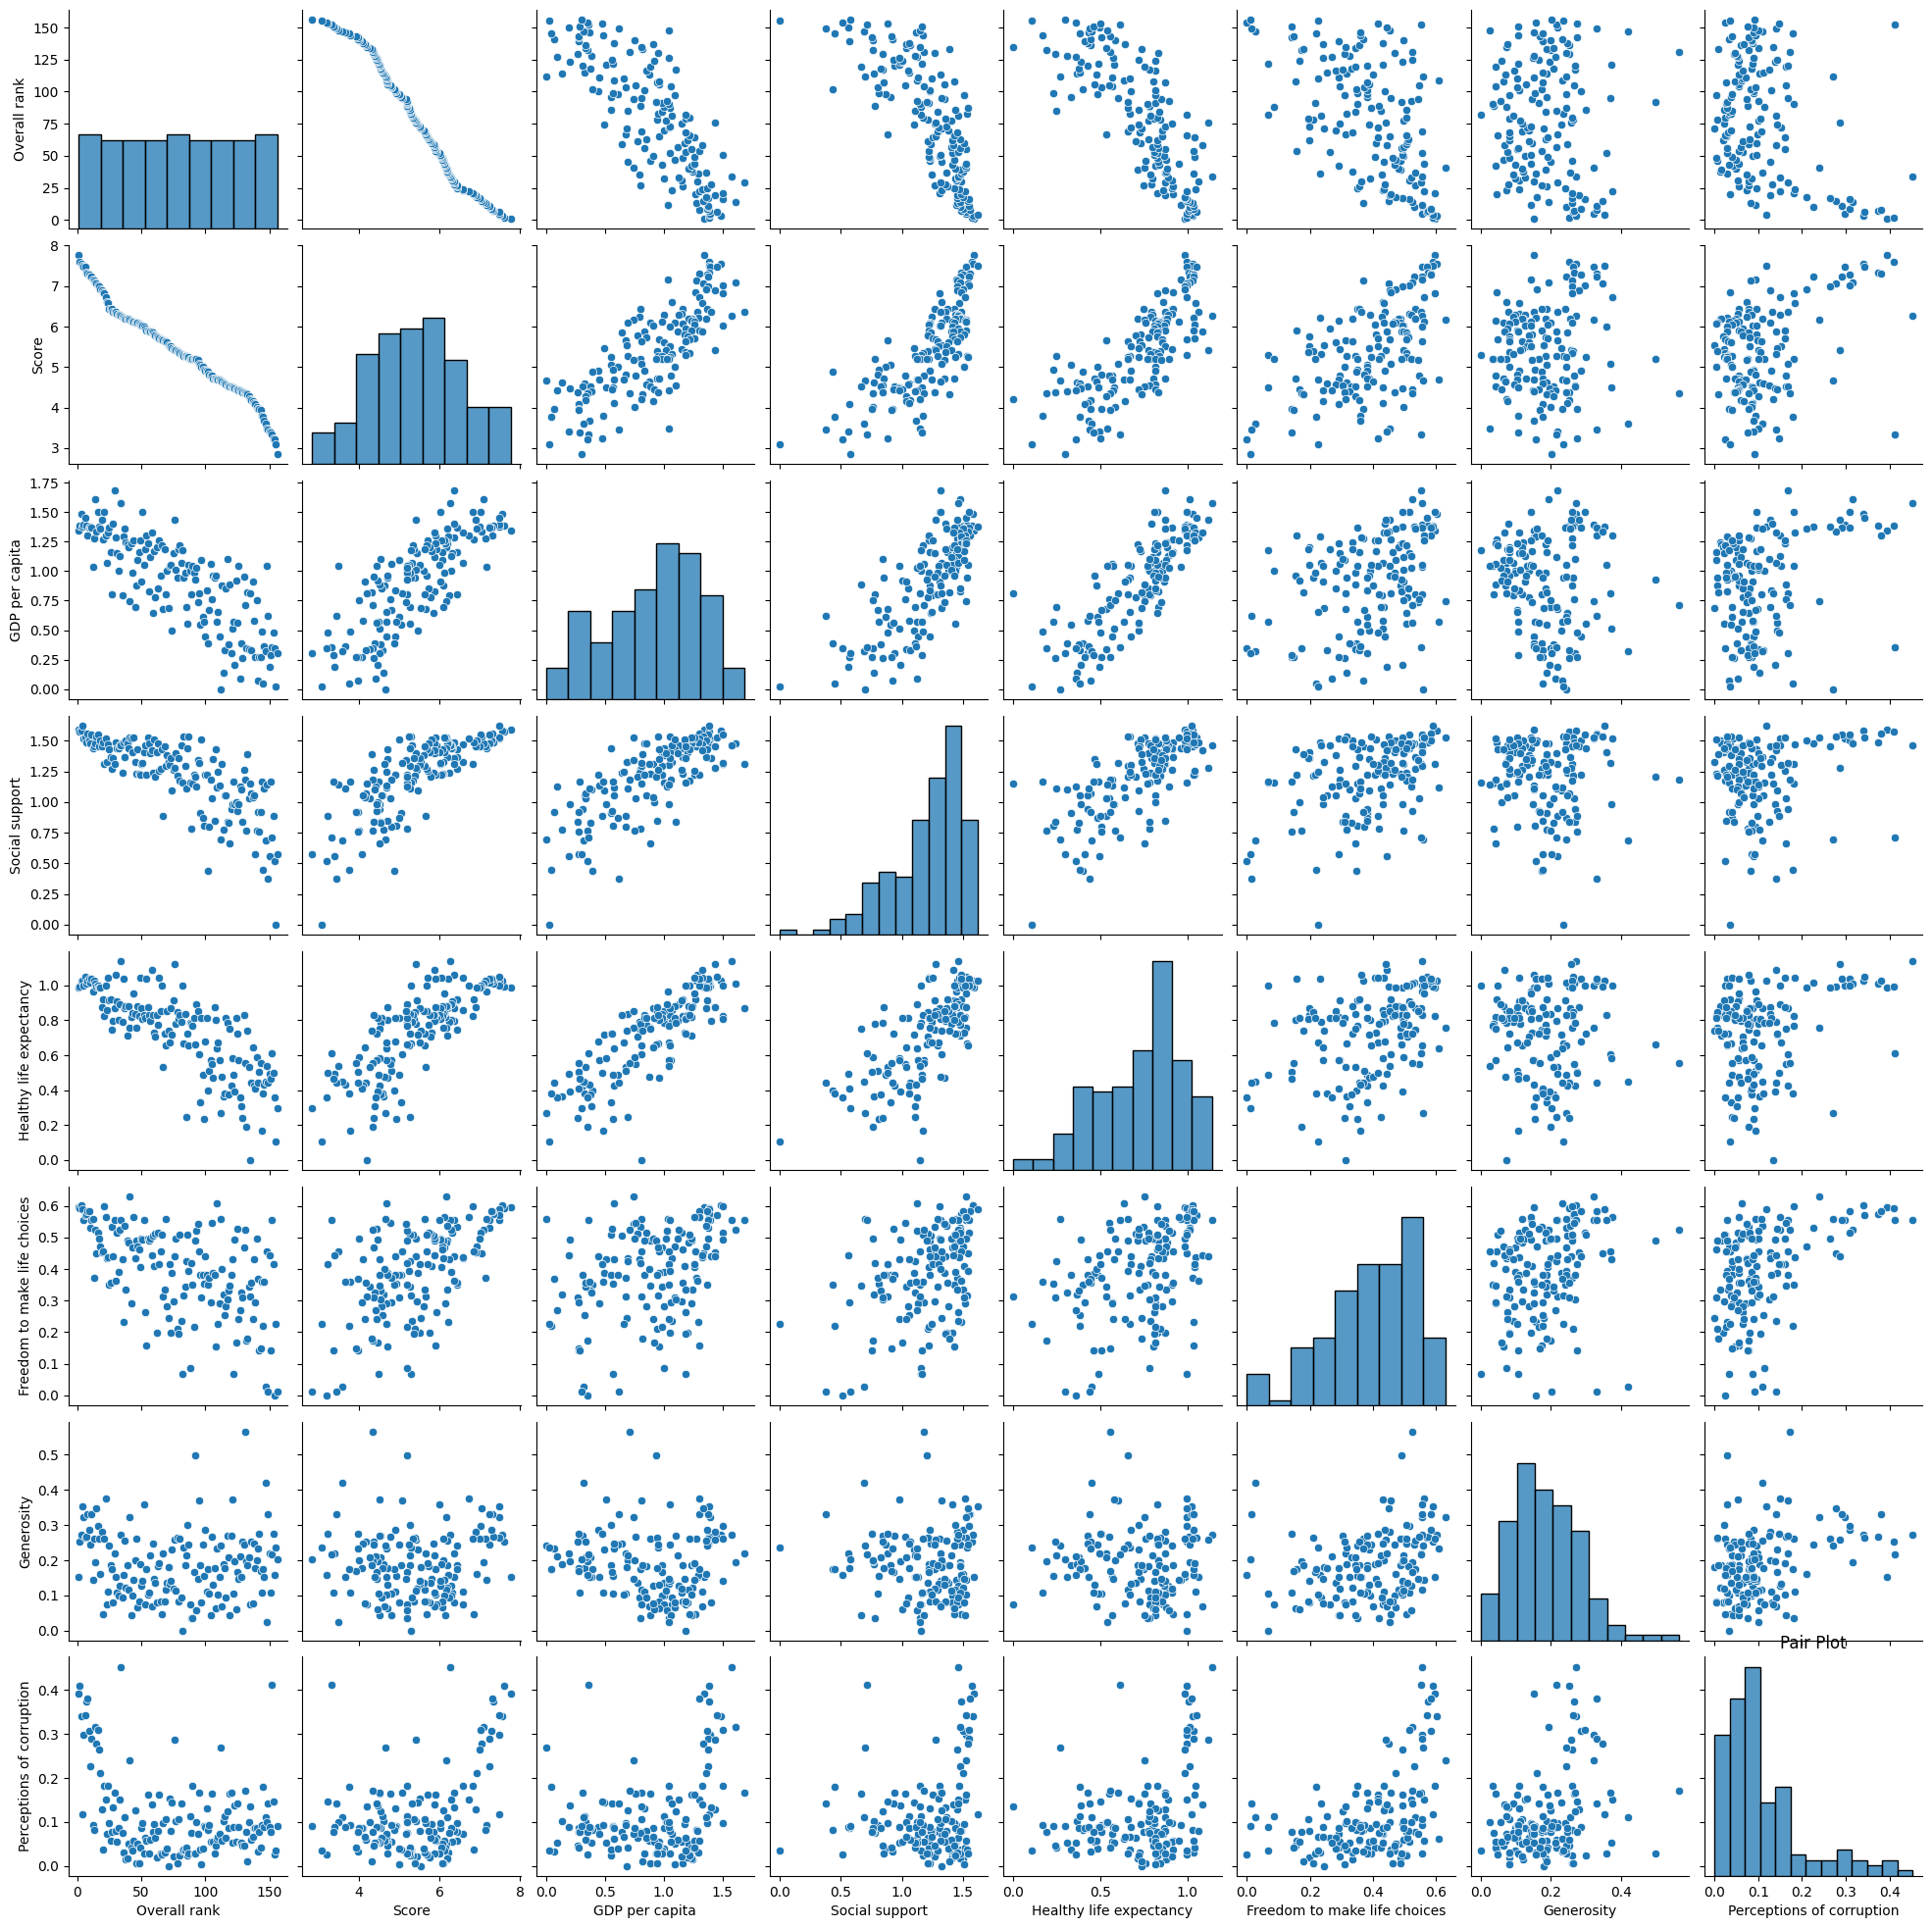

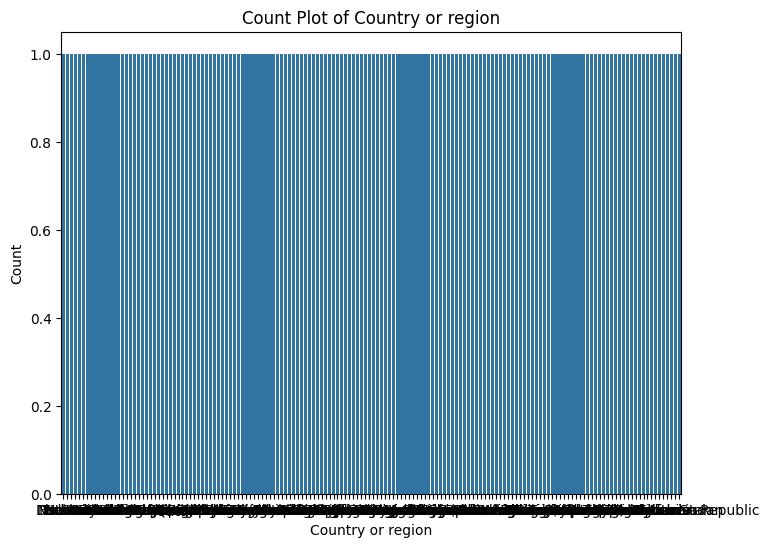


 
 The plotting of data is completed, pls continue with any questions 
 
 
Enter your question: what are the happiest countries to live in?, give me top 10 countries


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Data summary: Mean: Overall rank                    78.500000
Score                            5.407096
GDP per capita                   0.905147
Social support                   1.208814
Healthy life expectancy          0.725244
Freedom to make life choices     0.392571
Generosity                       0.184846
Perceptions of corruption        0.110603
dtype: float64, Median: Overall rank                    78.5000
Score                            5.3795
GDP per capita                   0.9600
Social support                   1.2715
Healthy life expectancy          0.7890
Freedom to make life choices     0.4170
Generosity                       0.1775
Perceptions of corruption        0.0855
dtype: float64, Mode: Overall rank                    1.000
Score                           5.208
GDP per capita                  0.960
Social support                  1.465
Healthy life expectancy         0.815
Freedom to make life choices    0.498
Generosity                      0.153
Perceptions 

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Data summary: Mean: Overall rank                    78.500000
Score                            5.407096
GDP per capita                   0.905147
Social support                   1.208814
Healthy life expectancy          0.725244
Freedom to make life choices     0.392571
Generosity                       0.184846
Perceptions of corruption        0.110603
dtype: float64, Median: Overall rank                    78.5000
Score                            5.3795
GDP per capita                   0.9600
Social support                   1.2715
Healthy life expectancy          0.7890
Freedom to make life choices     0.4170
Generosity                       0.1775
Perceptions of corruption        0.0855
dtype: float64, Mode: Overall rank                    1.000
Score                           5.208
GDP per capita                  0.960
Social support                  1.465
Healthy life expectancy         0.815
Freedom to make life choices    0.498
Generosity                      0.153
Perceptions 

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Data summary: Mean: Overall rank                    78.500000
Score                            5.407096
GDP per capita                   0.905147
Social support                   1.208814
Healthy life expectancy          0.725244
Freedom to make life choices     0.392571
Generosity                       0.184846
Perceptions of corruption        0.110603
dtype: float64, Median: Overall rank                    78.5000
Score                            5.3795
GDP per capita                   0.9600
Social support                   1.2715
Healthy life expectancy          0.7890
Freedom to make life choices     0.4170
Generosity                       0.1775
Perceptions of corruption        0.0855
dtype: float64, Mode: Overall rank                    1.000
Score                           5.208
GDP per capita                  0.960
Social support                  1.465
Healthy life expectancy         0.815
Freedom to make life choices    0.498
Generosity                      0.153
Perceptions 

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Data summary: Mean: Overall rank                    78.500000
Score                            5.407096
GDP per capita                   0.905147
Social support                   1.208814
Healthy life expectancy          0.725244
Freedom to make life choices     0.392571
Generosity                       0.184846
Perceptions of corruption        0.110603
dtype: float64, Median: Overall rank                    78.5000
Score                            5.3795
GDP per capita                   0.9600
Social support                   1.2715
Healthy life expectancy          0.7890
Freedom to make life choices     0.4170
Generosity                       0.1775
Perceptions of corruption        0.0855
dtype: float64, Mode: Overall rank                    1.000
Score                           5.208
GDP per capita                  0.960
Social support                  1.465
Healthy life expectancy         0.815
Freedom to make life choices    0.498
Generosity                      0.153
Perceptions 

In [ ]:
#@title Main function call and ignore warnings
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Or, to ignore specific warnings:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Your code here

if __name__ == "__main__":
  main()